# Принятие решений в бизнесе. А/В - тестирование.

### Описание проекта

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

### Описание данных
**Данные для первой части**
Файл /datasets/hypothesis.csv. 
* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Данные для второй части**
Файл /datasets/orders.csv. 
* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv. 
* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста

### Обзор данных.

In [1]:
#импортируем библиотеки
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 150) #ширина отображаемых колонок

In [2]:
# сохраним в переменную и изучим таблицу с гипотезами
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [3]:
# сохраним в переменную и изучим таблицу с заказами
orders = pd.read_csv('/datasets/orders.csv')
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [5]:
# сохраним в переменную и изучим таблицу с пользователями
visitors = pd.read_csv('/datasets/visitors.csv')
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [6]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [7]:
# проверка дубликатов в таблицах 
orders.duplicated().sum()

0

In [8]:
visitors.duplicated().sum()

0

In [9]:
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [10]:
# проверим есть ли пересечения в группах (общих пользователей)
# посчитаем количество уникальных групп для каждого пользователя
orders.groupby(by = 'visitorId').agg({'group': 'nunique'})

,group
visitorId,
5114589,1
6958315,1
8300375,2
11685486,1
39475350,1
...,...
4266935830,2
4278982564,1
4279090005,1


**Вывод:** Изучили данные, увидели с чем предстоит работать на следующих этапах. 

### Приоритизация гипотез.
В файле /datasets/hypothesis.csv **9 гипотез** по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

**Задачи:**
1. Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
2. Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
3. Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

#### Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [11]:
# посчитаем ICE для гипотез и добавим полученные значения ICE к существующей таблице
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']

round(hypothesis[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False), 1)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


**Вывод:** ТОП-3 приоритетных гипотезы: 

8. Запустить акцию, дающую скидку на товар в день.

0. Добавить два новых канала привлечения трафика.

7. Добавить форму подписки на все основные страницы.


#### Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [12]:
# посчитаем RICE для гипотез и добавим полученные значения RICE к существующей таблице
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
round(hypothesis[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False), 1)

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


**Вывод:** ТОП-3 приоритетных гипотезы: 

7. Добавить форму подписки на все основные страницы.

2. Добавить блоки рекомендаций товаров на сайт.

0. Добавить два новых канала привлечения трафика.


#### Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.
Reach — скольких пользователей затронет изменение, которое вы хотите внести; 

### Анализ A/B-теста
Вы провели A/B-тест и получили результаты, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.

**Задачи:**
Проанализируйте A/B-тест:
1. Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.
2. Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.
3. Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.
4. Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.
5. Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.
6. Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.
7. Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.
8. Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.
9. Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.
10. Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.
11. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.
12. Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения.
13. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.
14. Примите решение по результатам теста и объясните его. Варианты решений: 
- Остановить тест, зафиксировать победу одной из групп. 
- Остановить тест, зафиксировать отсутствие различий между группами. 
- Продолжить тест.

#### Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

In [13]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 

In [14]:
# cоберём агрегированные кумулятивные по дням данные о заказах
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [15]:
# аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [16]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Построим графики кумулятивной выручки по дням и группам A/B-тестирования:

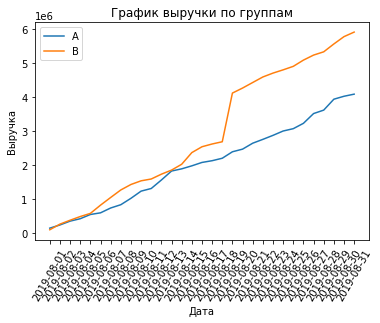

In [17]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.rcParams["figure.figsize"] = (9,4)
plt.legend()
plt.title('График выручки по группам')  # название графика
plt.xlabel('Дата')  # название оси X 
plt.ylabel('Выручка')  # название оси Y
plt.xticks(rotation = 60)
plt.show()

**Вывод:** Выручка почти равномерно увеличивается в течение всего теста. 
Однако графики выручки обеих групп в нескольких точках резко растут. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. 

#### Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

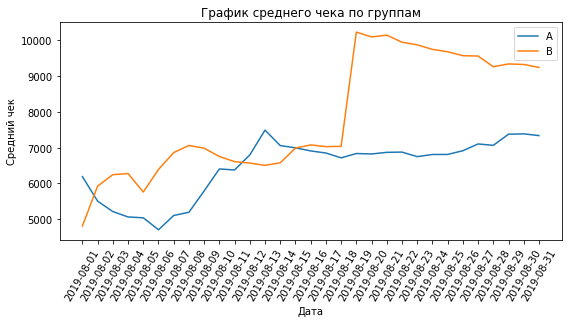

In [18]:
# построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.rcParams["figure.figsize"] = (9,4)
plt.legend() 
plt.title('График среднего чека по группам')  # название графика
plt.xlabel('Дата')  # название оси X 
plt.ylabel('Средний чек')  # название оси Y
plt.xticks(rotation = 60)
plt.show()

**Вывод:** Средний чек по группе В ближе к концу теста рекзко возрастает. Возможно, в группу B во второй половине теста попали крупные заказы (резкий всплеск на графике).

#### Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

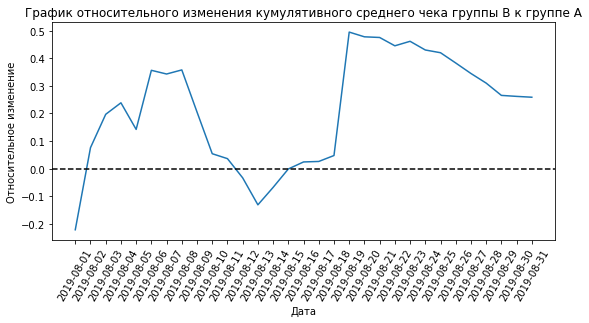

In [19]:
# построим график относительного различия для среднего чека, добавим горизонтальную ось

# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.rcParams["figure.figsize"] = (9,4)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')  # название графика
plt.xlabel('Дата')  # название оси X 
plt.ylabel('Относительное изменение')  # название оси Y
plt.xticks(rotation = 60)
plt.show()

**Вывод:** В нескольких точках график различия между сегментами резко «скачет». Что еще раз говорит о крупных заказах и выбросах.

#### Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.

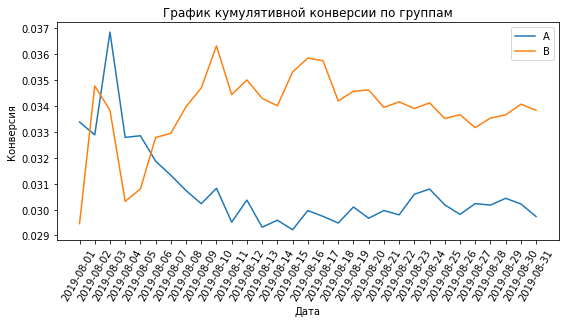

In [20]:
# аналогично проанализируем график кумулятивной конверсии
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.rcParams["figure.figsize"] = (9,4)
plt.legend()
plt.title('График кумулятивной конверсии по группам')  # название графика
plt.xlabel('Дата')  # название оси X 
plt.ylabel('Конверсия')  # название оси Y
plt.xticks(rotation = 60)
plt.show()

**Вывод:** Конверсия группы В вырвалась вперёд и зафиксировалась, а конверсия группы А просела и также зафиксировалась 

#### Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.

In [21]:
# Построим график относительного различия кумулятивных конверсий

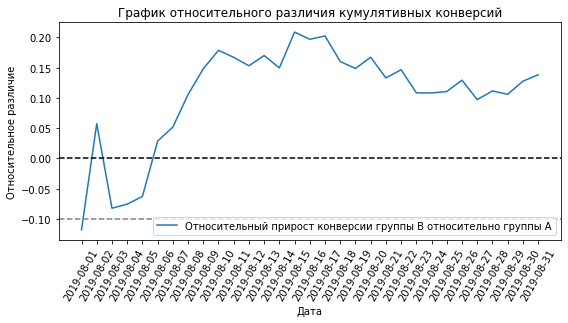

In [22]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.title('График относительного различия кумулятивных конверсий')  # название графика
plt.xlabel('Дата')  # название оси X 
plt.ylabel('Относительное различие')  # название оси Y
plt.xticks(rotation = 60)
plt.show()

**Вывод:** В начале теста группа B значительно проигрывала группе A, затем вырвалась вперёд. 
В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. Сперва стоит проанализировать аномалии. 

#### Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

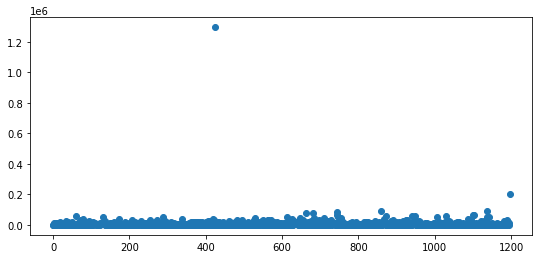

In [23]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 

**Вывод:** Есть несколько выбивающихся дорогих заказов. 

#### Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [24]:
np.percentile(orders['revenue'], [95, 99]) 

array([28000. , 58233.2])

**Вывод:** Не более 5% заказов дороже 28 000 рублей и не более 1% дороже 58 233 рублей. Для отсечения аномалий будем использовать 99% перцентиль.

In [25]:
# подсчитаем количество заказов по пользователям
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByUsers.columns = ['visitorId', 'transactionId']

print(ordersByUsers.sort_values(by='transactionId', ascending=False).head(10)) 

       visitorId  transactionId
1023  4256040402             11
591   2458001652             11
569   2378935119              9
487   2038680547              8
44     199603092              5
744   3062433592              5
55     237748145              5
917   3803269165              5
299   1230306981              5
897   3717692402              5


**Вывод:** Есть пользователи, которые совершали 5, 8, 9, 11 заказов. Значительно больше, чем обычный пользователь за неделю.

(array([937.,  64.,  17.,   3.,   6.,   0.,   0.,   1.,   1.,   2.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 10 artists>)

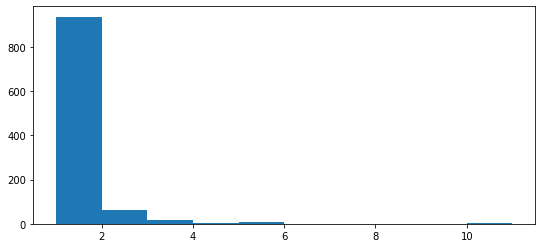

In [26]:
# построим гистрограмму распределения количества заказов на одного пользователя
plt.hist(ordersByUsers['transactionId']) 

**Вывод:** Большинство покупателей заказывали только один раз. Однако доля пользователей с 2-4 заказами тоже значительна.

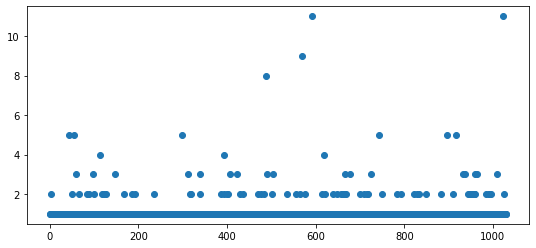

In [27]:
# построим точечную диаграмму числа заказов на одного пользователя
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['transactionId']) 

In [28]:
# посчитаем выборочные перцентили количества заказов на одного пользователя
np.percentile(ordersByUsers['transactionId'], [90, 95, 99])

array([1., 2., 4.])

**Вывод:** Не более 5% пользователей оформляли больше чем 2 заказа. И 10% пользователей заказывали более 1 раза.
Разумно выбрать 2 заказа на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней. 

#### Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.

Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

Сформулируем гипотезы. 

Нулевая: различий в конверсии между группами нет. 

Альтернативная: различия в конверсии между группами есть.

In [29]:
# подготовим данные
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Названия столбцов данных:
- date — дата;
- ordersPerDateA — количество заказов в выбранную дату в группе A;
- revenuePerDateA — суммарная выручка в выбранную дату в группе A;
- ordersPerDateB — количество заказов в выбранную дату в группе B;
- evenuePerDateB — суммарная выручка в выбранную дату в группе B;
- ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
- revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
- ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
- revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
- visitorsPerDateA — количество пользователей в выбранную дату в группе A;
- visitorsPerDateB — количество пользователей в выбранную дату в группе B;
- visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
- visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

In [30]:
# посчитаем статистическую значимость различия в конверсии между группами.
# создадим переменные ordersByUsersA и ordersByUsersB, в них для польз-ей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [31]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'transactionId']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'transactionId'] 

In [32]:
# объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. 
# тем, кто ничего не заказал, будут соответствовать нули.
sampleA = pd.concat([ordersByUsersA['transactionId'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['transactionId'])), name='transactionId')],axis=0)
sampleB = pd.concat([ordersByUsersB['transactionId'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['transactionId'])), name='transactionId')],axis=0)

In [33]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.017
0.138


**Вывод:** По «сырым» данным есть различия в конверсии групп A и B.
Первое число — p-value = 0.017 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Относительный выигрыш группы B равен 13.8%.

#### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.

Теперь проверим статистическую значимость различий в среднем чеке между сегментами. 

Нулевая гипотеза: различий в среднем чеке между группами нет. 

Альтернативная гипотеза: различия в среднем чеке между группами есть.

In [34]:
# чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов.
# и найдём относительные различия в среднем чеке между группами
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.729
0.259


**Вывод:** P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Средний чек группы B выше среднего чека группы A.

#### Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения.


Напомним, что найденные в прошлых уроках 95-й и 99-й перцентили средних чеков равны 28 000 и 58 233 рубля. 

А 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказа на пользователя.

Примем за аномальных пользователей тех, кто совершил от 2 заказов или совершил заказ дороже 30 000 рублей. Так мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 2 — **usersWithManyOrders** и пользователей, совершивших заказы дороже 30 000 — **usersWithExpensiveOrders**. Объединим их в таблице **abnormalUsers**.

In [35]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['transactionId'] > 2]['visitorId'],
        ordersByUsersB[ordersByUsersB['transactionId'] > 2]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormalUsers.head()

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitorId, dtype: int64

In [36]:
# узнаем, сколько всего аномальных пользователей 
abnormalUsers.shape[0]

68

Всего 68 аномальных пользователей.

Узнаем, как их действия повлияли на результаты теста. 

Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [37]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['transactionId'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['transactionId'])
            ),
            name='transactionId',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['transactionId'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['transactionId'])
            ),
            name='transactionId',
        ),
    ],
    axis=0,
) 

In [38]:
# применим статистический критерий Манна-Уитни к полученным выборкам
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.013
0.172


**Вывод:** Результаты по конверсии практически не изменились.

#### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

In [39]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

0.720
-0.023


**Вывод:** P-value практически не изменился. Однако второе значение стало отрацательным, то есть средний чек группы В ниже среднего чека группы А. 

### Общие выводы тестирования 

#### Примите решение по результатам теста и объясните его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.

Итак, 
1. Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
2. По сырым данным нет статистически значимого различия по среднему чеку между группами. Однако после удаления аномалий второе значение стало отрацательным, то есть средний чек группы В ниже среднего чека группы А.
3. График различия конверсии между группами сообщает, что результаты группы B лучше группы A.
4. График различия среднего чека колеблется. Сделать из этого графика определённые выводы нельзя. 
**Таким образом, достаточно ясно видно преимущество группы В, тест можно останосить и признать победу группы В.** 